In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform, randint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
char_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_character_corpus.csv', index_col = ['play', 'name'])

In [3]:
type_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_play_corpus.csv', index_col = ['play'])

In [4]:
colon = slice(None)

- tragedy/comedy column for predictions, MNB, look for other things that work well on language data.

In [57]:
char_xlist = char_df.columns.tolist()
char_xlist.remove('character_dies')

char_X = char_df[char_xlist]

char_y = char_df['character_dies']

char_X_train, char_X_test, char_y_train, char_y_test = \
train_test_split(char_X, char_y, random_state = 42, stratify = char_y, test_size = .2)

sc = StandardScaler()

char_Xs_train = sc.fit_transform(char_X_train)
char_Xs_test = sc.transform(char_X_test)
char_Xs = sc.transform(char_X)

In [6]:
type_xlist = type_df.columns.tolist()
type_xlist.remove('play_type')

type_X = type_df[type_xlist]

type_y = type_df['play_type']

type_X_train, type_X_test, type_y_train, type_y_test = train_test_split(type_X, type_y, random_state = 42, stratify = type_y)

sc = StandardScaler()

type_Xs_train = sc.fit_transform(type_X_train)
type_Xs_test = sc.transform(type_X_test)
type_Xs = sc.transform(type_X)

- Move PCA here with images.

In [62]:
pca = PCA(random_state=42)
char_Z_train = pca.fit_transform(char_X_train)

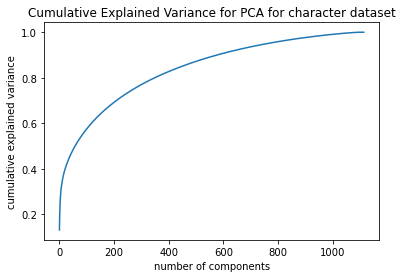

In [64]:
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for PCA for character dataset')
plt.show()

In [68]:
char_pca = PCA(random_state=42, svd_solver='full')
char_Z_train = char_pca.fit_transform(char_X_train)
char_Z_test = char_pca.transform(char_X_test)
char_Z = char_pca.transform(char_X)

- SMOTE

In [103]:
smt = SMOTE(random_state = 42, k_neighbors = 25, n_jobs = -1)
char_Xsm_train, char_ysm_train = smt.fit_resample(char_X_train, char_y_train)

- Boosted naive bayes

In [115]:
nb = GaussianNB()
char_bnb_pipe = AdaBoostClassifier(base_estimator=nb, random_state = 42)

char_bnb_params = {
    'n_estimators': randint(10, 100),
    'learning_rate': loguniform(.001, 10),
}

char_bnb_rs = RandomizedSearchCV(estimator = char_bnb_pipe,
                     param_distributions = char_bnb_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [116]:
char_bnb_rs.fit(char_Xsm_train, char_ysm_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.94203734        nan 0.94253239 0.94203734        nan 0.94153736
        nan 0.94203734        nan 0.94203734 0.93112901 0.94203734
 0.94203734 0.94203734 0.93410669 0.94203734        nan        nan
 0.94203734 0.93112901        nan 0.92964386 0.93906212 0.92964386
 0.93162406 0.94253239 0.94005221 0.94203734 0.94203734 0.92964386
        nan 0.94203734 0.93906212 0.94203734 0.94253239 0.94203734
        nan 0.94302744 0.94203734 0.94203734 0.93360918 0.94203734
 0.94203734 0.93112901 0.93906212 0.93906212        nan        nan
 0.94352495 0.93063396]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(base_estimator=GaussianNB(),
                                                random_state=42),
                   n_iter=50, n_jobs=8,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023430CA9AF0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023403A3CA30>},
                   random_state=42, scoring='roc_auc')

In [120]:
train_preds = char_bnb_rs.best_estimator_.predict(char_X_train)
test_preds = char_bnb_rs.best_estimator_.predict(char_X_test)

metrics.roc_auc_score(char_y_train, train_preds), metrics.roc_auc_score(char_y_test, test_preds)

(1.0, 0.43174217087260564)

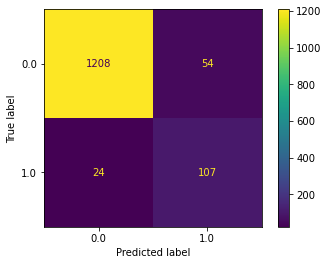

In [118]:
plot_confusion_matrix(char_bnb_rs.best_estimator_, char_X, char_y)

In [123]:
pickle.dump(char_bnb_rs.best_estimator_, open('../models/BoostedNaiveBayes.pkl', 'wb'))

- MNBchar

In [104]:
char_mnb_pipe = MultinomialNB(fit_prior = False)

char_mnb_params = {
    'alpha': uniform(0, 1)
}

char_mnb_rs = RandomizedSearchCV(estimator = char_mnb_pipe,
                     param_distributions = char_mnb_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [105]:
char_mnb_rs.fit(char_Xsm_train, char_ysm_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(fit_prior=False), n_iter=50,
                   n_jobs=8,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023430FC82E0>},
                   random_state=42, scoring='roc_auc')

In [113]:
train_preds = char_mnb_rs.best_estimator_.predict(char_X_train)
test_preds = char_mnb_rs.best_estimator_.predict(char_X_test)

metrics.roc_auc_score(char_y_train, train_preds), metrics.roc_auc_score(char_y_test, test_preds)

(0.9511114257397706, 0.6714806932198237)

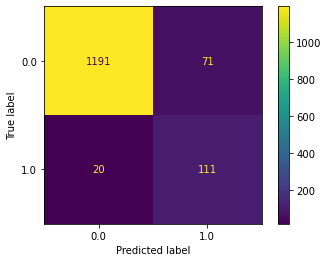

In [107]:
plot_confusion_matrix(char_mnb_rs.best_estimator_, char_X, char_y)

In [124]:
pickle.dump(char_mnb_rs.best_estimator_, open('../models/MultinomialNaiveBayes.pkl', 'wb'))

In [10]:
weights = {key: value for key, value in zip(char_X.columns.tolist(), char_mnb_rs.best_estimator_.feature_log_prob_[0])}
weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1], reverse = True)}

In [11]:
weights

{'NOUN_mean': -3.860723003600704,
 'NOUN_median': -3.9346601705256,
 'neu_sentiment_median': -3.9805553377615785,
 'VERB_median': -4.011286181696584,
 'VERB_mean': -4.027813117623259,
 'neu_sentiment_mean': -4.056792883743045,
 'NOUN_std': -4.133037511126873,
 'PROPN_mean': -4.148436635894509,
 'PROPN_std': -4.1680004900882235,
 'VERB_std': -4.251590045141529,
 'character_name_std': -4.405956915294148,
 'compound_sentiment_mean': -4.460807534004693,
 'compound_sentiment_median': -4.488185552345204,
 'character_name_mean': -4.498941409257434,
 'ADJ_std': -4.596696805209204,
 'PROPN_median': -4.5967423343377325,
 'ADJ_mean': -4.936411458976731,
 'character_name_median': -5.20053462207707,
 'ADV_std': -5.398158168671477,
 'neu_sentiment_std': -5.402268493202288,
 'pos_sentiment_std': -5.667356705243882,
 'compound_sentiment_std': -5.842017150142941,
 'pos_sentiment_mean': -5.897850647084526,
 'neg_sentiment_std': -5.907080880406679,
 'come_std': -5.960010088173559,
 'liquid_body_substance

- Baseline accuracy.

In [14]:
char_df['character_dies'].value_counts(normalize = True)

0.0    0.905958
1.0    0.094042
Name: character_dies, dtype: float64

- Char logreg pipe.

In [15]:
logreg_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(random_state = 42, solver = 'liblinear', penalty = 'l1'))
])

logreg_params = {
    'logreg__tol': uniform(0, .1),
    'logreg__C': loguniform(0.0001, 100),
    'logreg__class_weight': Categorical(['balanced', None]),
    'logreg__max_iter': randint(1, 1000),
    'logreg__l1_ratio': uniform(0, 1)
}

logreg_rs_rocauc = RandomizedSearchCV(estimator = logreg_pipe,
                     param_distributions = logreg_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [18]:
%%time
logreg_rs_rocauc.fit(char_X_train, char_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Wall time: 7min 37s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(penalty='l1',
                                                                 random_state=42,
                                                                 solver='liblinear'))]),
                   n_iter=50, n_jobs=8,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002344B04DB20>,
                                        'logreg__class_weight': Categorical(categories=('balanced', None), prior=None),
                                        'logreg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002343FF51940>,
                                        'logreg__max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002344FB35070>,
                                     

In [19]:
train_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict(char_Xs_train)
test_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict(char_Xs_test)

metrics.roc_auc_score(char_y_train, train_preds), metrics.roc_auc_score(char_y_test, test_preds)

(1.0, 0.5201380897583429)

In [22]:
weights = {key: value for key, value in zip(char_xlist, logreg_rs_rocauc.best_estimator_['logreg'].coef_[0])}
weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1], reverse = True)}

In [23]:
weights

{'fill_std': 0.16128808743307177,
 'hair_std': 0.12192975609447756,
 'tyrant_mean': 0.11049044261046234,
 'dastard_mean': 0.10439435513692343,
 'emmanuel_mean': 0.10038391910040323,
 'thank_mean': 0.10027580900325579,
 'proportionable_syn_mean': 0.09159781248005434,
 'small_indefinite_quantity_hyp_median': 0.0908426570135347,
 'prosperous_mean': 0.0886749150523419,
 'advantage_std': 0.08772731608523224,
 'right_mean': 0.08515471418972792,
 'whever_mean': 0.0816202400783043,
 'pitfall_mean': 0.07675812339500288,
 'plant_tissue_hyp_mean': 0.07577847169568633,
 'injustice_mean': 0.07456105457917261,
 'boot_std': 0.07361388981884248,
 'erroneous_std': 0.07317911969555226,
 'forcible_mean': 0.07243727026759679,
 'fiftyfold_mean': 0.07206741647363119,
 'disputant_hyp_std': 0.07182386644033224,
 'distil_mean': 0.0713865401703324,
 'agent_hyp_std': 0.07092117430233046,
 'fle_mean': 0.0678658698676678,
 'exit_hyp_std': 0.06731248864169924,
 'drudge_std': 0.06624450445960275,
 'tell_syn_std': 0.

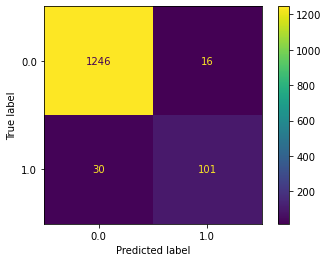

In [25]:
plot_confusion_matrix(logreg_rs_rocauc.best_estimator_['logreg'], char_Xs, char_y)

- Char NN with PCA.

In [ ]:
pca = PCA(n_components = 1000, random_state = 42)
char_Z_train = pca.fit_transform(char_Xs_train)
char_Z_test = pca.transform(char_Xs_test)
char_Z = pca.transform(char_Xs)

In [ ]:
%%time
clear_session()
model = Sequential()

model.add(Dense(30, activation = 'relu', input_shape = (1000,)))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

history = model.fit(char_Z_train, char_y_train, validation_data = (char_Z_test, char_y_test), batch_size = 512, 
                   epochs = 20, verbose = 0)

In [ ]:
plt.plot(history.epoch, history.history['loss'], c='g');      # green - training loss # Loss
plt.plot(history.epoch, history.history['val_loss'], c='b');  # blue - test loss # Val loss

- char_df predictions block

In [ ]:
char_pred_df = pd.DataFrame(index = char_df.index)

In [ ]:
char_pred_df['prob'] = [val[1] for val in char_mnb_rs.best_estimator_.predict_proba(char_X)]

In [ ]:
char_pred_df['pred'] = char_pred_df['prob'].map(lambda x: 1 if x >= .5 else 0)

In [ ]:
for play, name in index_without_number:
    char_pred_df.loc[(play, name), 'character_dies'] = char_df.loc[(play, name), 'character_dies']

In [ ]:
char_pred_df.sort_values(by = 'prob', inplace = True)

In [ ]:
plot_confusion_matrix(char_mnb_rs.best_estimator_, char_X, char_y)

In [ ]:
char_pred_df.loc[('titus-andronicus', colon), :]